#### I. Load Data and Import Dependencies

In [5]:
!pip install ultralytics==8.0.196
!pip install roboflow

  Using cached ultralytics-8.0.196-py3-none-any.whl.metadata (31 kB)
  Using cached thop-0.1.1.post2209072238-py3-none-any.whl.metadata (2.7 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Us

In [40]:
import os
import random
import pandas as pd
from PIL import Image
import cv2
import ultralytics
from ultralytics import YOLO
from ultralytics import RTDETR
from roboflow import Roboflow
from IPython.display import Video, display, Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from scipy.ndimage import gaussian_filter1d
from scipy.ndimage import gaussian_filter1d
import pathlib
import glob
from tqdm.notebook import trange, tqdm
import warnings
warnings.filterwarnings('ignore')
from glob import glob

In [7]:
ultralytics.checks()

Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 33.6/78.2 GB disk)


In [8]:
home = os.getcwd()

!mkdir {home}/datasets
%cd {home}/datasets

/content/datasets


In [9]:
os.listdir()

[]

In [10]:
rf = Roboflow(api_key="zrwkyhNL7WvkKMWx8SDg")
project = rf.workspace("usmanchaudhry622-gmail-com").project("traffic-and-road-signs")
dataset = project.version(1).download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Traffic-and-Road-Signs-1 in yolov8:: 100%|██████████| 20012/20012 [00:02<00:00, 7188.91it/s]


In [26]:
# Define path to train, validation and test set of images and labels
train_images = '/content/datasets/Traffic-and-Road-Signs-1/train/images'
train_labels = '/content/datasets/Traffic-and-Road-Signs-1/train/labels'

test_images = '/content/datasets/Traffic-and-Road-Signs-1/test/images'
test_labels = '/content/datasets/Traffic-and-Road-Signs-1/test/labels'

valid_images = '/content/datasets/Traffic-and-Road-Signs-1/valid/images'
valid_labels = '/content/datasets/Traffic-and-Road-Signs-1/valid/labels'

In [27]:
# Count the number of images in each set
print(f"Number of images in train set: {len(glob(os.path.join(train_images, '*')))}")
print(f"Number of images in validation set: {len(glob(os.path.join(val_images, '*')))}")
print(f"Number of images in test set: {len(glob(os.path.join(test_images, '*')))}")

Number of images in train set: 7092
Number of images in validation set: 1884
Number of images in test set: 1024


In [28]:
image_files_train = os.listdir(train_images)
image_files_valid = os.listdir(valid_images)
image_files_test = os.listdir(test_images)

#### II. Visualize Random Image Samples

In [13]:
# Choose 9 random image files from the list to visalize
random_images_train = random.sample(image_files_train, 9)

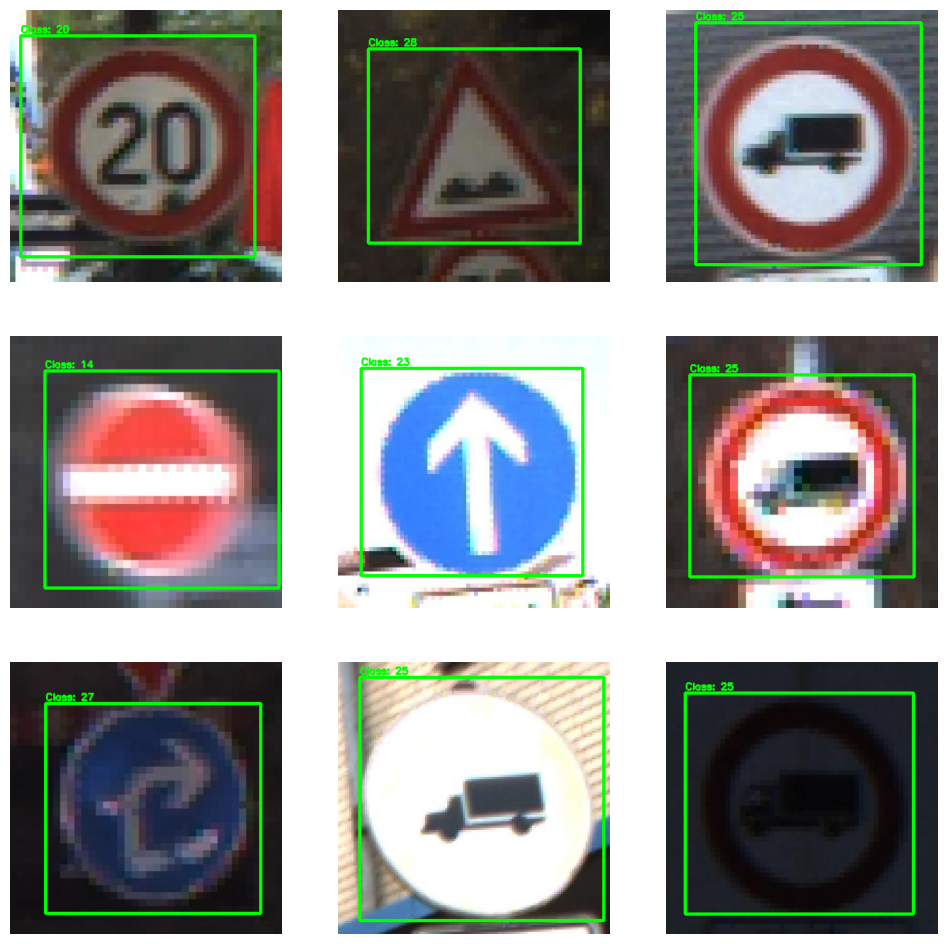

In [ ]:
# Set plot dim and pallette
sns.set_style('darkgrid')
fig, axs = plt.subplots(3, 3, figsize=(12, 12))

# Iterate through random samples and plot them with respective labels
for i, image_file in enumerate(random_images_train):
    row = i // 3
    col = i % 3

    image_path = os.path.join(train_images, image_file)
    image = cv2.imread(image_path)

    # Load labels
    label_file = os.path.splitext(image_file)[0] + ".txt"
    label_path = os.path.join(train_labels, label_file)
    with open(label_path, "r") as f:
        labels = f.read().strip().split("\n")

    # Loop over the labels
    for label in labels:
        if len(label.split()) != 5: # Ensure label is in YOLO format (i.e., class_id, x_center, y_center, widt,h height)
            continue
        class_id, x_center, y_center, width, height = map(float, label.split())
        x_min = int((x_center - width/2) * image.shape[1])
        y_min = int((y_center - height/2) * image.shape[0])
        x_max = int((x_center + width/2) * image.shape[1])
        y_max = int((y_center + height/2) * image.shape[0])

        # Draw bounding box
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 3)
        # Get  label
        class_label = str(int(class_id))
        label_text = f"Class: {class_label}"

        cv2.putText(image, label_text, (x_min, y_min - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    axs[row, col].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[row, col].axis('off')

plt.show()

#### III. Examine Image Dimensions and Channels

We already know that the dataset was resized to 416 x 416 dimensions with 3 channels; however, we will confirm that none of the images deviate from these dimensions before training models.

In [15]:
# Check dim of a sample image
sample_image_path = '/content/datasets/Traffic-and-Road-Signs-1/train/images/00002_00001_00011_png_jpg.rf.b74e549c60152058ecf46bd2f7c99425.jpg'
image = cv2.imread(sample_image_path)

h, w, c = image.shape
print(f"The image has dimensions {w}x{h} and {c} channels.")

The image has dimensions 416x416 and 3 channels.


In [16]:
# Check dim of all images in the dataset (average, max and min)
image_dimensions = [cv2.imread(os.path.join(train_images, img)).shape for img in image_files_train]
heights = [dim[0] for dim in image_dimensions]
widths = [dim[1] for dim in image_dimensions]

print(f"Average Image Width: {sum(widths)/len(widths)}")
print(f"Average Image Height: {sum(heights)/len(heights)}")
print(f"Max Image Width: {max(widths)}")
print(f"Max Image Height: {max(heights)}")

Average Image Width: 416.0
Average Image Height: 416.0
Max Image Width: 416
Max Image Height: 416


#### IV. Explore Class Distribution

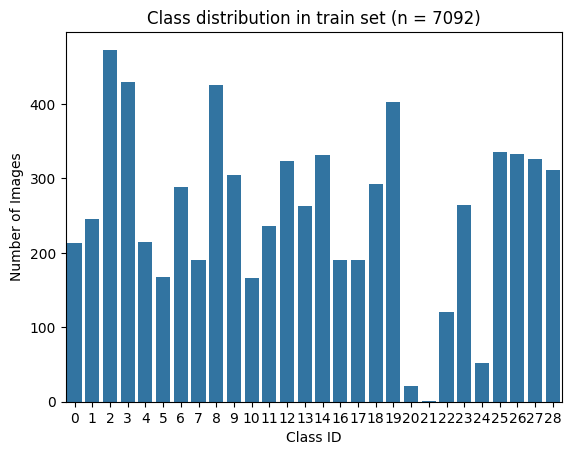

In [51]:
## Train set (n = 7092)

# Count the frequency of each class
class_counts_train = Counter()
for image_file in image_files_train:
    label_file = os.path.splitext(image_file)[0] + ".txt"
    label_path = os.path.join(train_labels, label_file)
    with open(label_path, "r") as f:
        labels = f.read().strip().split("\n")
        for label in labels:
            if len(label.split()) == 5:
                class_id = int(label.split()[0])
                class_counts_train[class_id] += 1

# print("Class Distribution:")
# for class_id, count in sorted(class_counts.items(), key=lambda item: item[1]):
#     print(f"Class {class_id}: {count} images")

# Plot the distribution
sns.barplot(x=list(class_counts_train.keys()), y=list(class_counts_train.values()))
plt.xlabel('Class ID')
plt.ylabel('Number of Images')
plt.title('Class distribution in train set (n = 7092)')
plt.show()

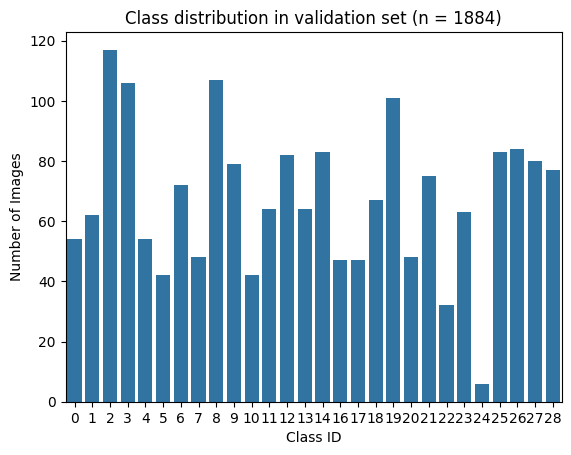

In [34]:
## Validation set (n = 7092)

# Count the frequency of each class
class_counts_valid = Counter()
for image_file in image_files_valid:
    label_file = os.path.splitext(image_file)[0] + ".txt"
    label_path = os.path.join(valid_labels, label_file)
    with open(label_path, "r") as f:
        labels = f.read().strip().split("\n")
        for label in labels:
            if len(label.split()) == 5:
                class_id = int(label.split()[0])
                class_counts_valid[class_id] += 1

# Plot the distribution
sns.barplot(x=list(class_counts_valid.keys()), y=list(class_counts_valid.values()))
plt.xlabel('Class ID')
plt.ylabel('Number of Images')
plt.title('Class distribution in validation set (n = 1884)')
plt.show()

We can see that some of the classes are severely underrepresented in training sample (e.g., class 20 and 21), but have sufficient samples in validation set.

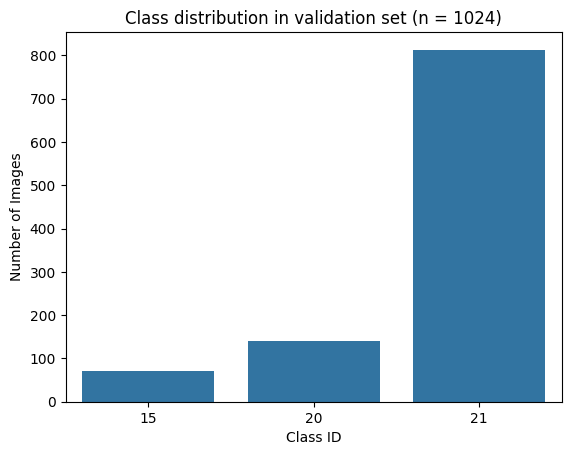

In [36]:
## Test set (n = 1024)

# Count the frequency of each class
class_counts_test = Counter()
for image_file in image_files_test:
    label_file = os.path.splitext(image_file)[0] + ".txt"
    label_path = os.path.join(test_labels, label_file)
    with open(label_path, "r") as f:
        labels = f.read().strip().split("\n")
        for label in labels:
            if len(label.split()) == 5:
                class_id = int(label.split()[0])
                class_counts_test[class_id] += 1

# Plot the distribution
sns.barplot(x=list(class_counts_test.keys()), y=list(class_counts_test.values()))
plt.xlabel('Class ID')
plt.ylabel('Number of Images')
plt.title('Class distribution in validation set (n = 1024)')
plt.show()

#### V. Assess Sample Distribution Within Each Class

In [52]:
def visualize_samples_for_class(train_images, train_labels, class_id, num_images=5):
    # Mapping from class ID to image paths
    class_to_images = defaultdict(list)

    # Iterate through all images and collect class-to-image mappings
    for image_file in os.listdir(train_images):
        label_file = os.path.splitext(image_file)[0] + ".txt"
        label_path = os.path.join(train_labels, label_file)

        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                labels = f.read().strip().split("\n")
                for label in labels:
                    if len(label.split()) == 5:
                        current_class_id = int(label.split()[0])
                        if current_class_id == class_id:
                            class_to_images[class_id].append(image_file)

    image_files = class_to_images.get(class_id, [])
    if image_files:
        num_images = min(num_images, len(image_files))  # Ensure we don't try to show more images than available

        # Create a figure with subplots
        fig, axs = plt.subplots(1, num_images, figsize=(num_images * 5, 5))  # Adjust figure size based on num_images
        fig.suptitle(f"Class: {class_id}", fontsize=16)

        # Ensure axs is always iterable
        if num_images == 1:
            axs = [axs]

        # Display each image
        for i, image_file in enumerate(image_files[:num_images]):
            image_path = os.path.join(train_images, image_file)
            image = cv2.imread(image_path)

            label_file = os.path.splitext(image_file)[0] + ".txt"
            label_path = os.path.join(train_labels, label_file)

            with open(label_path, "r") as f:
                labels = f.read().strip().split("\n")

                for label in labels:
                    if len(label.split()) == 5:
                        _, x_center, y_center, width, height = map(float, label.split())
                        x_min = int((x_center - width / 2) * image.shape[1])
                        y_min = int((y_center - height / 2) * image.shape[0])
                        x_max = int((x_center + width / 2) * image.shape[1])
                        y_max = int((y_center + height / 2) * image.shape[0])

                        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

            axs[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            axs[i].axis('off')

        plt.show()
    else:
        print(f"No images found for Class {class_id}")


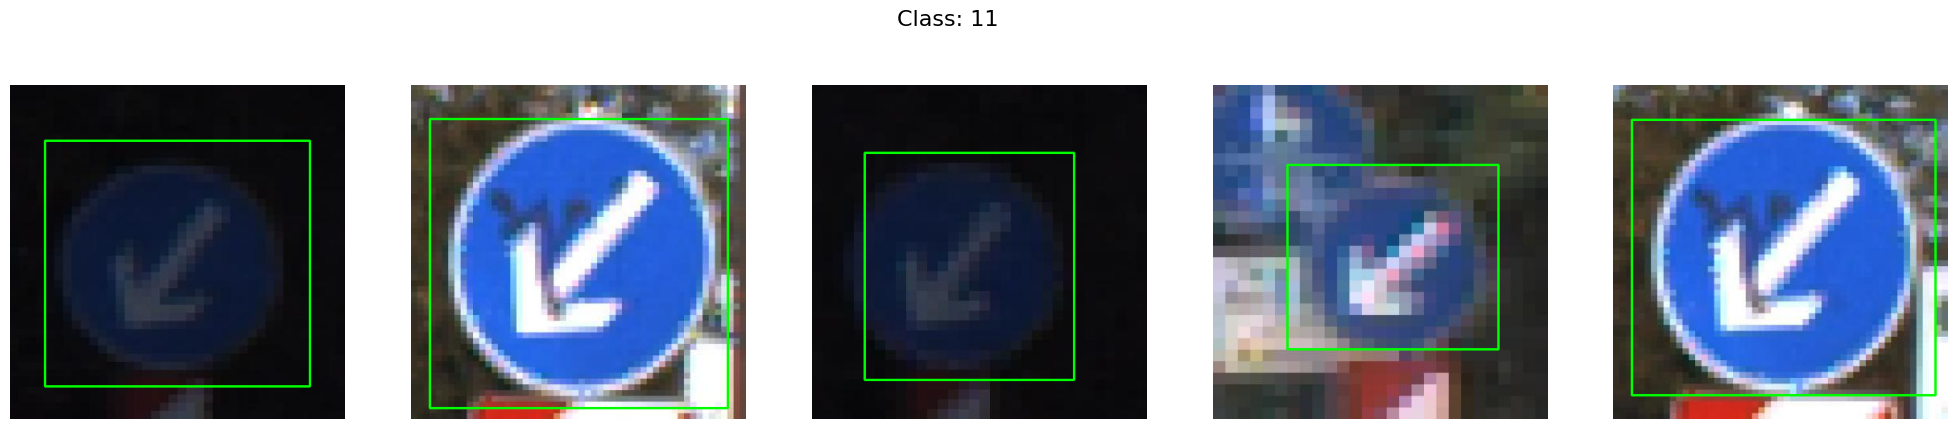

In [53]:
visualize_samples_for_class(train_images, train_labels, class_id=11, num_images=5)
